In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

project_root = Path("/dmj/fizmed/mmarzec/licencjat_neuro/magisterka")
sys.path.insert(0, str(project_root / "src"))

In [2]:
from preprocessing.processing import EEGPreprocessor # type:ignore
from preprocessing.windowing import EEGWindower # type:ignore
from preprocessing.constants import * # type:ignore

In [3]:
BASE_DIR, EDF_DIR, BASE_CSV_PATH # type:ignore

('/dmj/fizmed/mmarzec/licencjat_neuro',
 '/dmj/fizmed/mmarzec/licencjat_neuro/baza_elm19/ELM19_edfs',
 '/dmj/fizmed/mmarzec/licencjat_neuro/baza_elm19/ELM19_info.csv')

In [4]:
import pandas as pd
data = pd.read_csv(BASE_CSV_PATH) # type:ignore
data_szc = data[data['institution_id'] == 'SZC']

In [5]:
data_szc['examination_id'].iloc[10]

'20220512-160627-{7ae0e8a5-d013-4a07-a989-b2e27958ba6e}'

In [6]:
edf_path = f"{EDF_DIR}/{data_szc['examination_id'].iloc[0]}.edf" # type:ignore
institution_id_szc = data_szc['institution_id'].iloc[0]

Załadowanie danych z wybranego zapisu (pierwszego przykładu) ze szpitala SZC

In [7]:
preprocessor = EEGPreprocessor.from_edf(
    edf_path=edf_path,
    institution_id=institution_id_szc,
    preload=True
)

print(f"✓ Załadowano {len(preprocessor.raw.ch_names)} kanałów")
print(f"  Częstotliwość próbkowania: {preprocessor.raw.info['sfreq']} Hz")
print(f"  Czas trwania: {preprocessor.raw.times[-1]:.1f} s")
print(f"  Kanały: {preprocessor.raw.ch_names}")

Extracting EDF parameters from /dmj/fizmed/mmarzec/licencjat_neuro/baza_elm19/ELM19_edfs/20220512-152511-{61074308-a109-40b1-97cb-43dcb90e915b}.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 199999  =      0.000 ...   799.996 secs...
✓ Załadowano 23 kanałów
  Częstotliwość próbkowania: 250.0 Hz
  Czas trwania: 800.0 s
  Kanały: ['EEG Fp1', 'EEG Fp2', 'EEG F7', 'EEG F3', 'EEG Fz', 'EEG F4', 'EEG F8', 'EEG T3', 'EEG C3', 'EEG Cz', 'EEG C4', 'EEG T4', 'EEG T5', 'EEG P3', 'EEG Pz', 'EEG P4', 'EEG T6', 'EEG O1', 'EEG O2', 'S1', 'S2', 'S3', 'S4']


Preprocessing pipeline 

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


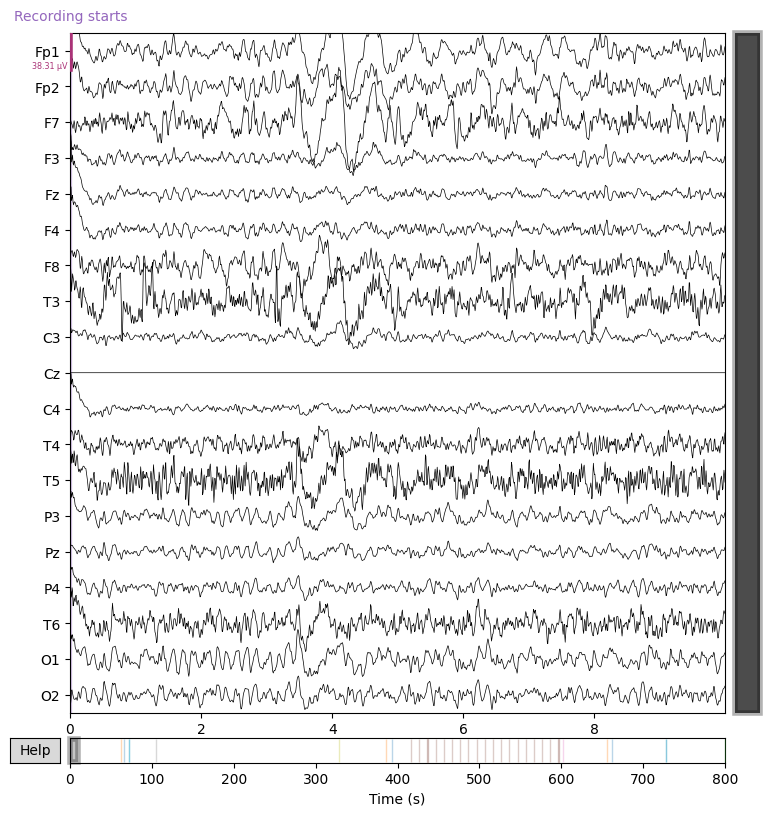


✓ Preprocessing zakończony!
  Kanały po standaryzacji: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
  Częstotliwość po resamplingu: 128.0 Hz


In [35]:
CHOICE_OF_REFERENCE = ["Cz"] # or average or Fz 

raw_preprocessed = preprocessor.preprocess(
    ref_channels=CHOICE_OF_REFERENCE,                        # Referencja: average, 'Cz', lub lista kanałów 
    sfreq=DEFAULT_SFREQ,                        # Resample do 128 Hz
    notch_freq= DEFAULT_NOTCH_FREQ,             # Notch filter: 50 Hz (Europa) lub 60 Hz (USA)
    hp_cutoff= DEFAULT_HP_CUTOFF,               # High-pass: 0.5 Hz (usuwa dryft)
    lp_cutoff= DEFAULT_LP_CUTOFF,               # Low-pass: 45 Hz
    plot=True,                                  # Ustaw True aby zobaczyć sygnał
    percentile=DEFAULT_PERCENTILE               # Percentyl dla skalowania wykresu
)

print("\n✓ Preprocessing zakończony!")
print(f"  Kanały po standaryzacji: {raw_preprocessed.ch_names}")
print(f"  Częstotliwość po resamplingu: {raw_preprocessed.info['sfreq']} Hz")

Segmentacja na ramki

In [9]:
windower = EEGWindower(raw_preprocessed)

Detected units: V
Typical amplitude: 3.78e-06 V


In [10]:
clean_frames, info = windower.process_fixed_frames(
    frame_duration=6.0,          # 6-sekundowe ramki
    drop_last_incomplete=True,   # Usuń ostatnią niepełną ramkę
    min_amplitude=1.0,           # < 1 µV = płaska (elektroda odłączona)
    max_amplitude=600.0,         # > 600 µV = artefakt (ruch, mięśnie)
    min_flat_channels=10,         # Min. kanałów płaskich do odrzucenia
    min_bad_channels=1,          # Min. kanałów z artefaktem do odrzucenia
    verbose=True
)

print(f"\n✓ Segmentacja zakończona!")
print(f"  Shape ramek: {clean_frames.shape}")
print(f"  (n_frames, n_channels, n_samples_per_frame)")

Segmentation Info:
  Recording duration: 800.0s
  Frame duration: 6.0s (768 samples @ 128.0Hz)
  Total frames: 133

Frame Rejection Summary:
  Data units: V
  Thresholds: 1.0 µV = 1.00e-06 V, 600.0 µV = 6.00e-04 V
  Total frames: 133
  Rejected: 0 (0.0%)
    - Flat (< 1.0 µV): 0
    - High amplitude (> 600.0 µV): 0
  Clean frames: 133

✓ Segmentacja zakończona!
  Shape ramek: (133, 19, 768)
  (n_frames, n_channels, n_samples_per_frame)


Inspekcja przykładowych ramek


Frame 75 (original index: 75)
Time: 450.0 - 456.0 s


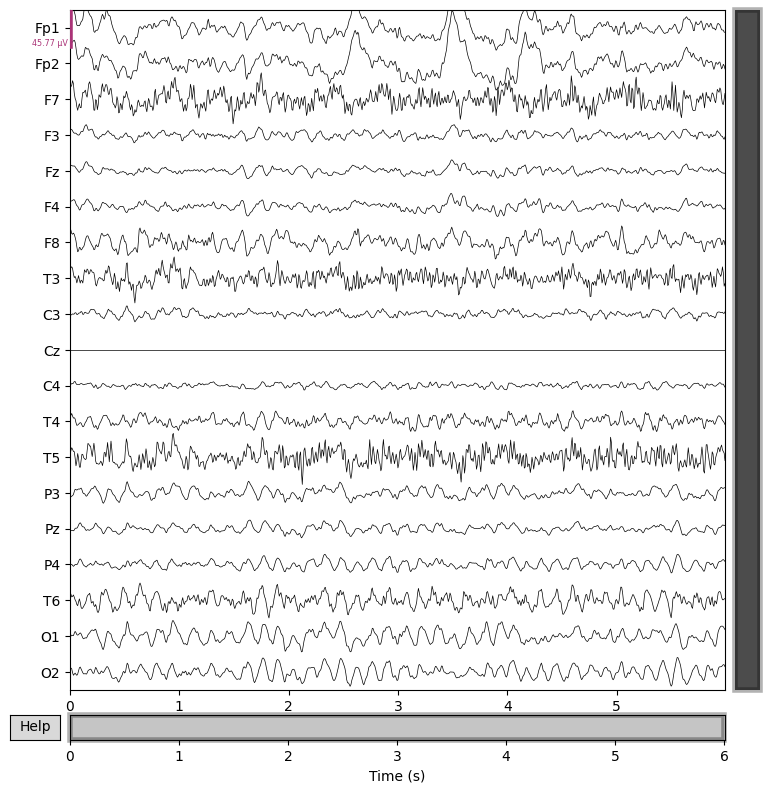


Frame 19 (original index: 19)
Time: 114.0 - 120.0 s


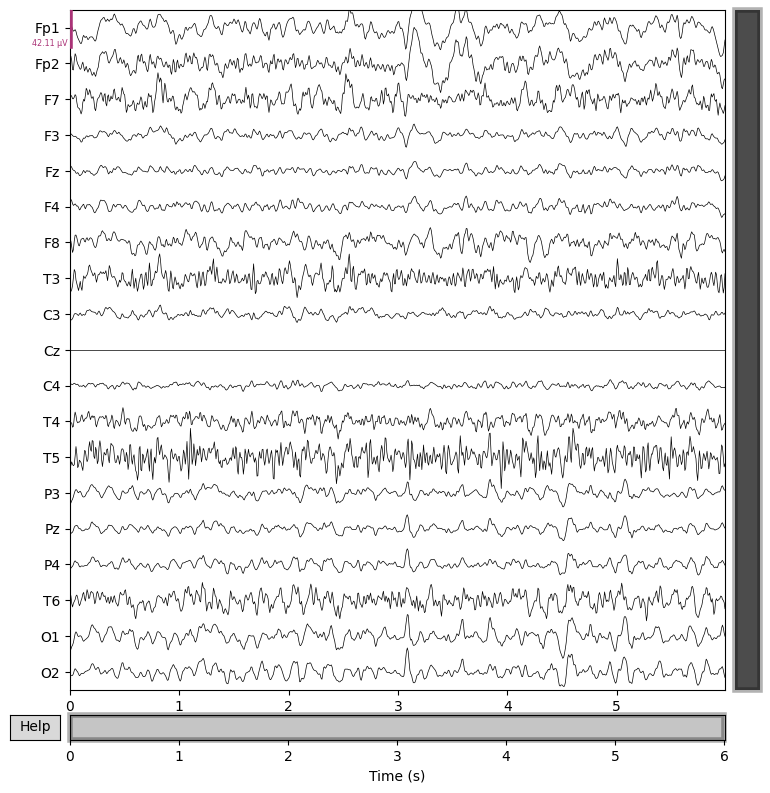


Frame 82 (original index: 82)
Time: 492.0 - 498.0 s


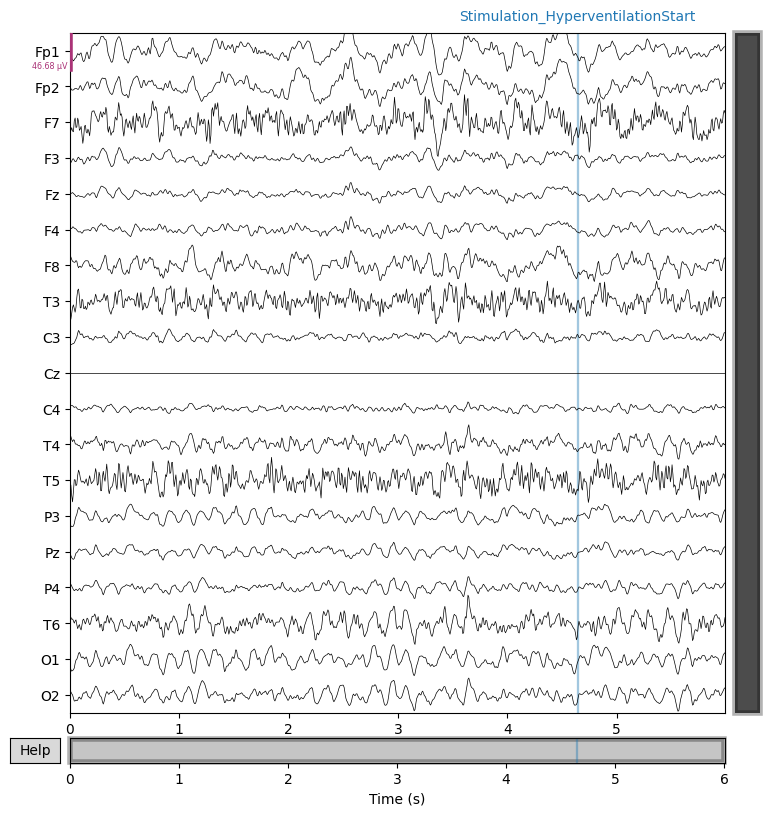

In [26]:
import numpy as np


# Pokaż 3 losowe czyste ramki w formacie EEG
n_examples = min(3, len(clean_frames))
random_indices = np.random.choice(len(clean_frames), n_examples, replace=False)

for frame_idx in random_indices:
    frame = clean_frames[frame_idx]
    
    # Original frame index (przed odrzuceniem)
    original_idx = info['clean_indices'][frame_idx]
    start_time, end_time = windower.get_frame_times(original_idx)
    
    # Pobierz odpowiedni fragment z raw (dla poprawnej wizualizacji)
    sfreq = raw_preprocessed.info['sfreq']
    start_sample = int(start_time * sfreq)
    end_sample = int(end_time * sfreq)
    
    # Stwórz tymczasowy Raw object dla tego fragmentu
    frame_raw = raw_preprocessed.copy().crop(tmin=start_time, tmax=end_time)
    
    # Oblicz scaling dla lepszej wizualizacji
    frame_data = frame_raw.get_data()
    if windower.data_in_volts:
        # Konwertuj V → µV dla wyświetlania
        scaling_value = np.percentile(np.abs(frame_data * 1e6), 99)
        ylabel = 'µV'
    else:
        scaling_value = np.percentile(np.abs(frame_data), 99)
        ylabel = 'µV'
    
    # Plot w stylu EEG
    print(f"\nFrame {frame_idx} (original index: {original_idx})")
    print(f"Time: {start_time:.1f} - {end_time:.1f} s")
    
    frame_raw.plot(
        duration=end_time - start_time,
        n_channels=len(raw_preprocessed.ch_names),
        scalings={'eeg': scaling_value if not windower.data_in_volts else scaling_value * 1e-6},
        title=f"Frame {frame_idx} - Clean EEG (original: {original_idx}, {start_time:.1f}-{end_time:.1f}s)",
        show=True,
        block=False
    )

In [12]:
print("\n" + "="*60)
print("SELEKCJA RAMEK WEDŁUG EVENTÓW")
print("="*60)

# Sprawdź dostępne eventy/annotacje w danych
if hasattr(raw_preprocessed, 'annotations') and len(raw_preprocessed.annotations) > 0:
    print(f"\nDostępne annotacje w danych:")
    unique_annotations = list(set([ann['description'] for ann in raw_preprocessed.annotations]))
    for i, ann_name in enumerate(unique_annotations, 1):
        count = sum(1 for ann in raw_preprocessed.annotations if ann['description'] == ann_name)
        print(f"  {i}. {ann_name} (n={count})")
else:
    print("\n⚠️  Brak annotacji w danych!")
    print("   Funkcje event-based nie będą dostępne.")


SELEKCJA RAMEK WEDŁUG EVENTÓW

Dostępne annotacje w danych:
  1. Stimulation_PhotostimulationStop (n=1)
  2. Stimulation_HyperventilationStop (n=1)
  3. Stimulation_HyperventilationStart (n=19)
  4. Eyes_Opened (n=3)
  5. Eyes_Closed (n=3)
  6. Recording starts (n=1)
  7. Technical_ExamPause (n=2)
  8. Stimulation_PhotostimulationStart (n=1)
  9. Recording ends (n=1)
  10. Technical_ExamResume (n=2)


In [13]:
EVENT_NAME = 'Eyes_Opened'  

print(f"\n" + "="*60)
print(f"WYSZUKIWANIE RAMEK Z EVENTEM: {EVENT_NAME}")
print("="*60)

if hasattr(raw_preprocessed, 'annotations') and len(raw_preprocessed.annotations) > 0:
    frames_event, indices_event, event_info = windower.find_frames_with_events(
        event_names=EVENT_NAME,
        clean_frames=clean_frames,
        clean_indices=info['clean_indices'],
        match_mode='contains',  # 'contains' dla point markers, 'overlap' dla intervalów
        min_overlap=0.0,  # Używane tylko dla match_mode='overlap'
        verbose=True
    )
    
    if len(frames_event) > 0:
        print(f"\n✓ Znaleziono {len(frames_event)} ramek z eventem '{EVENT_NAME}'")
        print(f"  Shape: {frames_event.shape}")
        
        # Pokaż mapowanie ramka→event
        print(f"\n  Przykładowe mapowanie (pierwsze 5 ramek):")
        for i, (frame_idx, events) in enumerate(list(event_info['frame_event_mapping'].items())[:5]):
            original_idx = indices_event[i]
            start, end = windower.get_frame_times(original_idx)
            print(f"    Frame {i} (original: {original_idx}): {start:.1f}-{end:.1f}s")
            for event in events:
                if 'event_onset' in event:
                    print(f"      - {event['event']}: onset={event['event_onset']:.1f}s, offset={event['time_offset']:.2f}s")
                else:
                    print(f"      - {event['event']}")
else:
    print("Pomijam - brak annotacji")


WYSZUKIWANIE RAMEK Z EVENTEM: Eyes_Opened
Event-based Frame Selection:
  Searched events: ['Eyes_Opened']
  Match mode: contains
  Events found: 3
  Point markers (duration=0): 3/3
  Total clean frames: 133
  Frames with events: 3 (2.3%)

  Event details:
    1. Eyes_Opened: 61.8s (point marker)
    2. Eyes_Opened: 385.9s (point marker)
    3. Eyes_Opened: 656.4s (point marker)

✓ Znaleziono 3 ramek z eventem 'Eyes_Opened'
  Shape: (3, 19, 768)

  Przykładowe mapowanie (pierwsze 5 ramek):
    Frame 0 (original: 10): 60.0-66.0s
      - Eyes_Opened: onset=61.8s, offset=1.80s
    Frame 1 (original: 64): 384.0-390.0s
      - Eyes_Opened: onset=385.9s, offset=1.94s
    Frame 2 (original: 109): 654.0-660.0s
      - Eyes_Opened: onset=656.4s, offset=2.39s


In [14]:
EVENT_GROUPS = {
    'eyes_opened': 'Eyes_Opened',      # ZMIEŃ NA SWOJE EVENTY!
    'eyes_closed': 'Eyes_Closed',
    # 'baseline': 'Baseline',
    # 'seizure': ['Seizure', 'Ictal']  # Można podać wiele eventów
}

if hasattr(raw_preprocessed, 'annotations') and len(raw_preprocessed.annotations) > 0:
    groups = windower.split_frames_by_events(
        event_groups=EVENT_GROUPS,
        clean_frames=clean_frames,
        clean_indices=info['clean_indices'],
        match_mode='contains',  # 'contains' dla point markers (duration=0)
        min_overlap=0.0,  # Używane tylko dla match_mode='overlap'
        verbose=True
    )
    
    # Dostęp do konkretnych grup
    print(f"\n" + "="*60)
    print("DOSTĘP DO GRUP")
    print("="*60)
    
    for group_name, (frames, indices, group_info) in groups.items():
        if len(frames) > 0:
            print(f"\nGrupa '{group_name}':")
            print(f"  Liczba ramek: {len(frames)}")
            print(f"  Shape: {frames.shape}")
            print(f"  Indeksy: {indices[:10]}..." if len(indices) > 10 else f"  Indeksy: {indices}")
            
else:
    print("Pomijam - brak annotacji")


SPLITTING FRAMES BY EVENTS

Group: eyes_opened
----------------------------------------
Event-based Frame Selection:
  Searched events: ['Eyes_Opened']
  Match mode: contains
  Events found: 3
  Point markers (duration=0): 3/3
  Total clean frames: 133
  Frames with events: 3 (2.3%)

  Event details:
    1. Eyes_Opened: 61.8s (point marker)
    2. Eyes_Opened: 385.9s (point marker)
    3. Eyes_Opened: 656.4s (point marker)

Group: eyes_closed
----------------------------------------
Event-based Frame Selection:
  Searched events: ['Eyes_Closed']
  Match mode: contains
  Events found: 3
  Point markers (duration=0): 3/3
  Total clean frames: 133
  Frames with events: 3 (2.3%)

  Event details:
    1. Eyes_Closed: 66.1s (point marker)
    2. Eyes_Closed: 393.5s (point marker)
    3. Eyes_Closed: 661.9s (point marker)

SUMMARY
  eyes_opened: 3 frames
  eyes_closed: 3 frames

  Total unique frames selected: 6/133

DOSTĘP DO GRUP

Grupa 'eyes_opened':
  Liczba ramek: 3
  Shape: (3, 19, 768


WIZUALIZACJA PORÓWNAWCZA GRUP

Grupa: eyes_opened
Time: 60.0 - 66.0 s


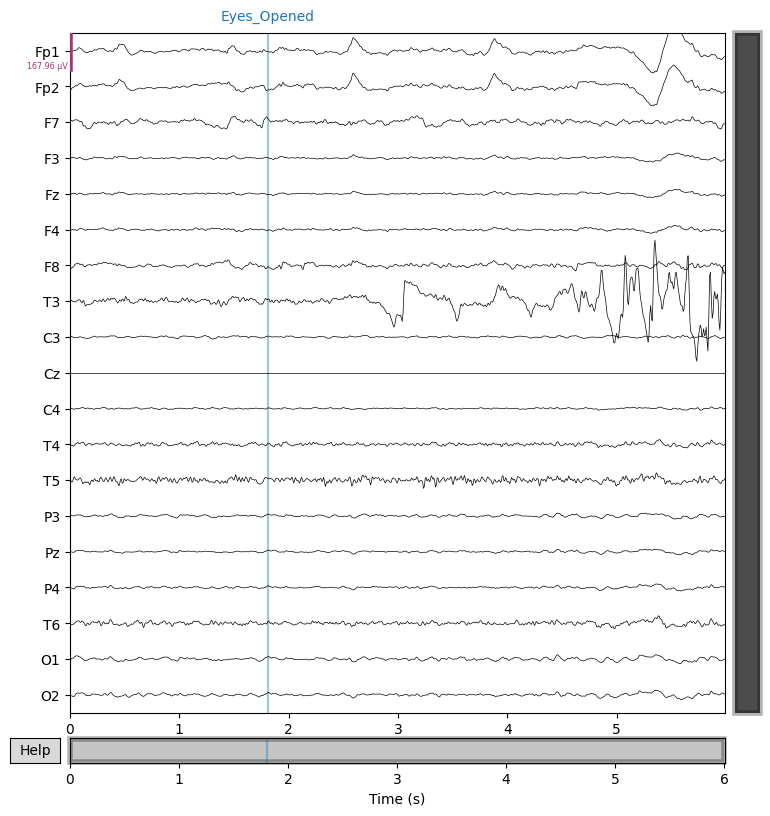


Grupa: eyes_closed
Time: 66.0 - 72.0 s


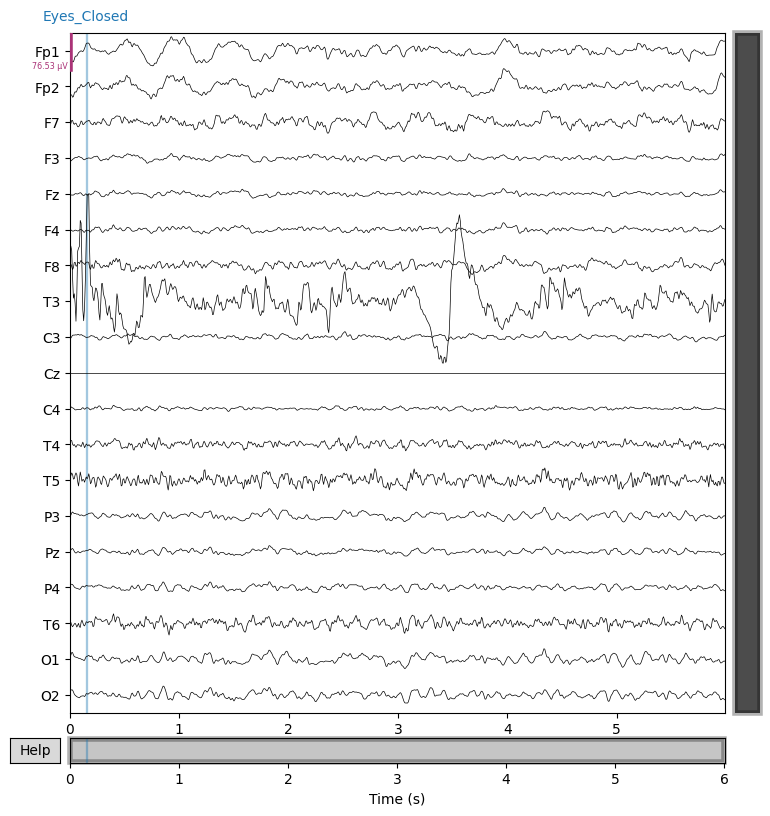

In [15]:
if hasattr(raw_preprocessed, 'annotations') and len(raw_preprocessed.annotations) > 0 and 'groups' in locals():
    print(f"\n" + "="*60)
    print("WIZUALIZACJA PORÓWNAWCZA GRUP")
    print("="*60)
    
    for group_name, (frames, indices, group_info) in groups.items():
        if len(frames) > 0:
            # Weź pierwszą ramkę z grupy
            frame_idx = 0
            original_idx = indices[frame_idx]
            start_time, end_time = windower.get_frame_times(original_idx)
            
            # Stwórz fragment Raw
            frame_raw = raw_preprocessed.copy().crop(tmin=start_time, tmax=end_time)
            
            # Oblicz scaling
            frame_data = frame_raw.get_data()
            if windower.data_in_volts:
                scaling_value = np.percentile(np.abs(frame_data * 1e6), 99)
            else:
                scaling_value = np.percentile(np.abs(frame_data), 99)
            
            print(f"\nGrupa: {group_name}")
            print(f"Time: {start_time:.1f} - {end_time:.1f} s")
            
            # Plot
            frame_raw.plot(
                duration=end_time - start_time,
                n_channels=len(raw_preprocessed.ch_names),
                scalings={'eeg': scaling_value if not windower.data_in_volts else scaling_value * 1e-6},
                title=f"Group '{group_name}' - Frame {frame_idx} ({start_time:.1f}-{end_time:.1f}s)",
                show=True,
                block=False
            )

First tests with DTF

In [16]:
from connectivity.mtmvar import mvar_plot_dense, DTF_multivariate, multivariate_spectra, mvar_criterion, AR_coeff, mvar_H, mvar_plot # type: ignore

In [18]:
chosen_index = 11
sim1 = clean_frames[chosen_index]
Fs = DEFAULT_SFREQ #type: ignore
N_chan, N_samp = sim1.shape
print(f"\n=== DATA CHARACTERISTICS ===")
print(f"Index of a frame in a EEG recording: {chosen_index}")
print(f"Number of channels: {N_chan}")
print(f"Number of samples: {N_samp}")
print(f"Sampling frequency: {Fs} Hz")
print(f"Data duration: {N_samp/Fs:.2f} seconds")
print(f"Data shape: {sim1.shape}")


=== DATA CHARACTERISTICS ===
Index of a frame in a EEG recording: 11
Number of channels: 19
Number of samples: 768
Sampling frequency: 128 Hz
Data duration: 6.00 seconds
Data shape: (19, 768)


In [20]:
print("Nazwy kanałów:", CH_NAMES) #type: ignore
cz_idx = CH_NAMES.index('Cz') #type: ignore
print(f"Indeks kanału referencyjnego: {cz_idx}")

# 2. Usuń kanał referencyjny
data_no_ref = np.delete(sim1, cz_idx, axis=0)
CH_NAMES_no_ref = [name for i, name in enumerate(CH_NAMES) if i != cz_idx] #type: ignore

print(f"Nowy kształt danych: {data_no_ref.shape}")
print(f"Nowe nazwy kanałów: {CH_NAMES_no_ref}")
N_chan, N_samp = data_no_ref.shape

Nazwy kanałów: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
Indeks kanału referencyjnego: 9
Nowy kształt danych: (18, 768)
Nowe nazwy kanałów: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']


In [21]:
max_p = 50         # Maximum model order to test
crit_type = 'AIC'   # Information criterion (AIC or BIC)
f = np.arange(0, 30, 0.1)  # Frequency range for analysis
N_f = f.shape[0]    # Number of frequency points

/dmj/fizmed/mmarzec/licencjat_neuro/magisterka/src/connectivity/mtmvar.py:704: RuntimeWarning: invalid value encountered in log
  crit[p-1] = np.log(np.linalg.det(Vr)) + 2 * p * k**2 / N
/dmj/fizmed/mmarzec/licencjat_neuro/magisterka/src/connectivity/mtmvar.py:704: RuntimeWarning: divide by zero encountered in log
  crit[p-1] = np.log(np.linalg.det(Vr)) + 2 * p * k**2 / N


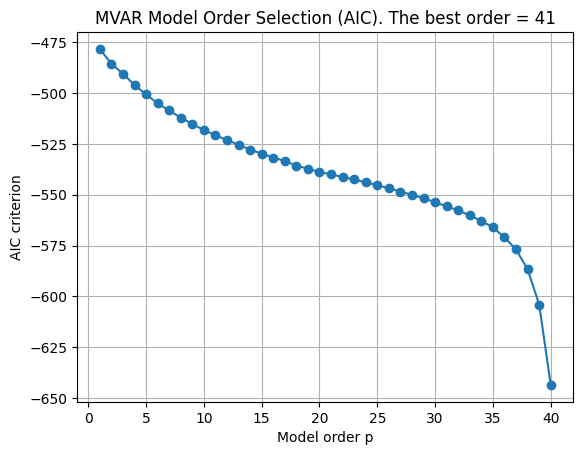

Optimal model order for all channels: p = 41


In [22]:
x = data_no_ref

# Estimate optimal model order for all channels
crit, p_range, p_opt = mvar_criterion(x, max_p, crit_type, True)
print(f"Optimal model order for all channels: p = {p_opt}")

# Estimate AR coefficients and compute transfer function
Ar, V = AR_coeff(x, p_opt)
H, _ = mvar_H(Ar, f, Fs)

# Compute multivariate spectrum
S_multivariate = np.zeros((N_chan, N_chan, N_f), dtype=np.complex128)
for fi in range(N_f):
    S_multivariate[:, :, fi] = H[:, :, fi].dot(V.dot(H[:, :, fi].T))

Diagonal (auto): moc/aktywność wewnątrz danego kanału
Off-diagonal (cross): połączenia/interakcje między różnymi kanałami

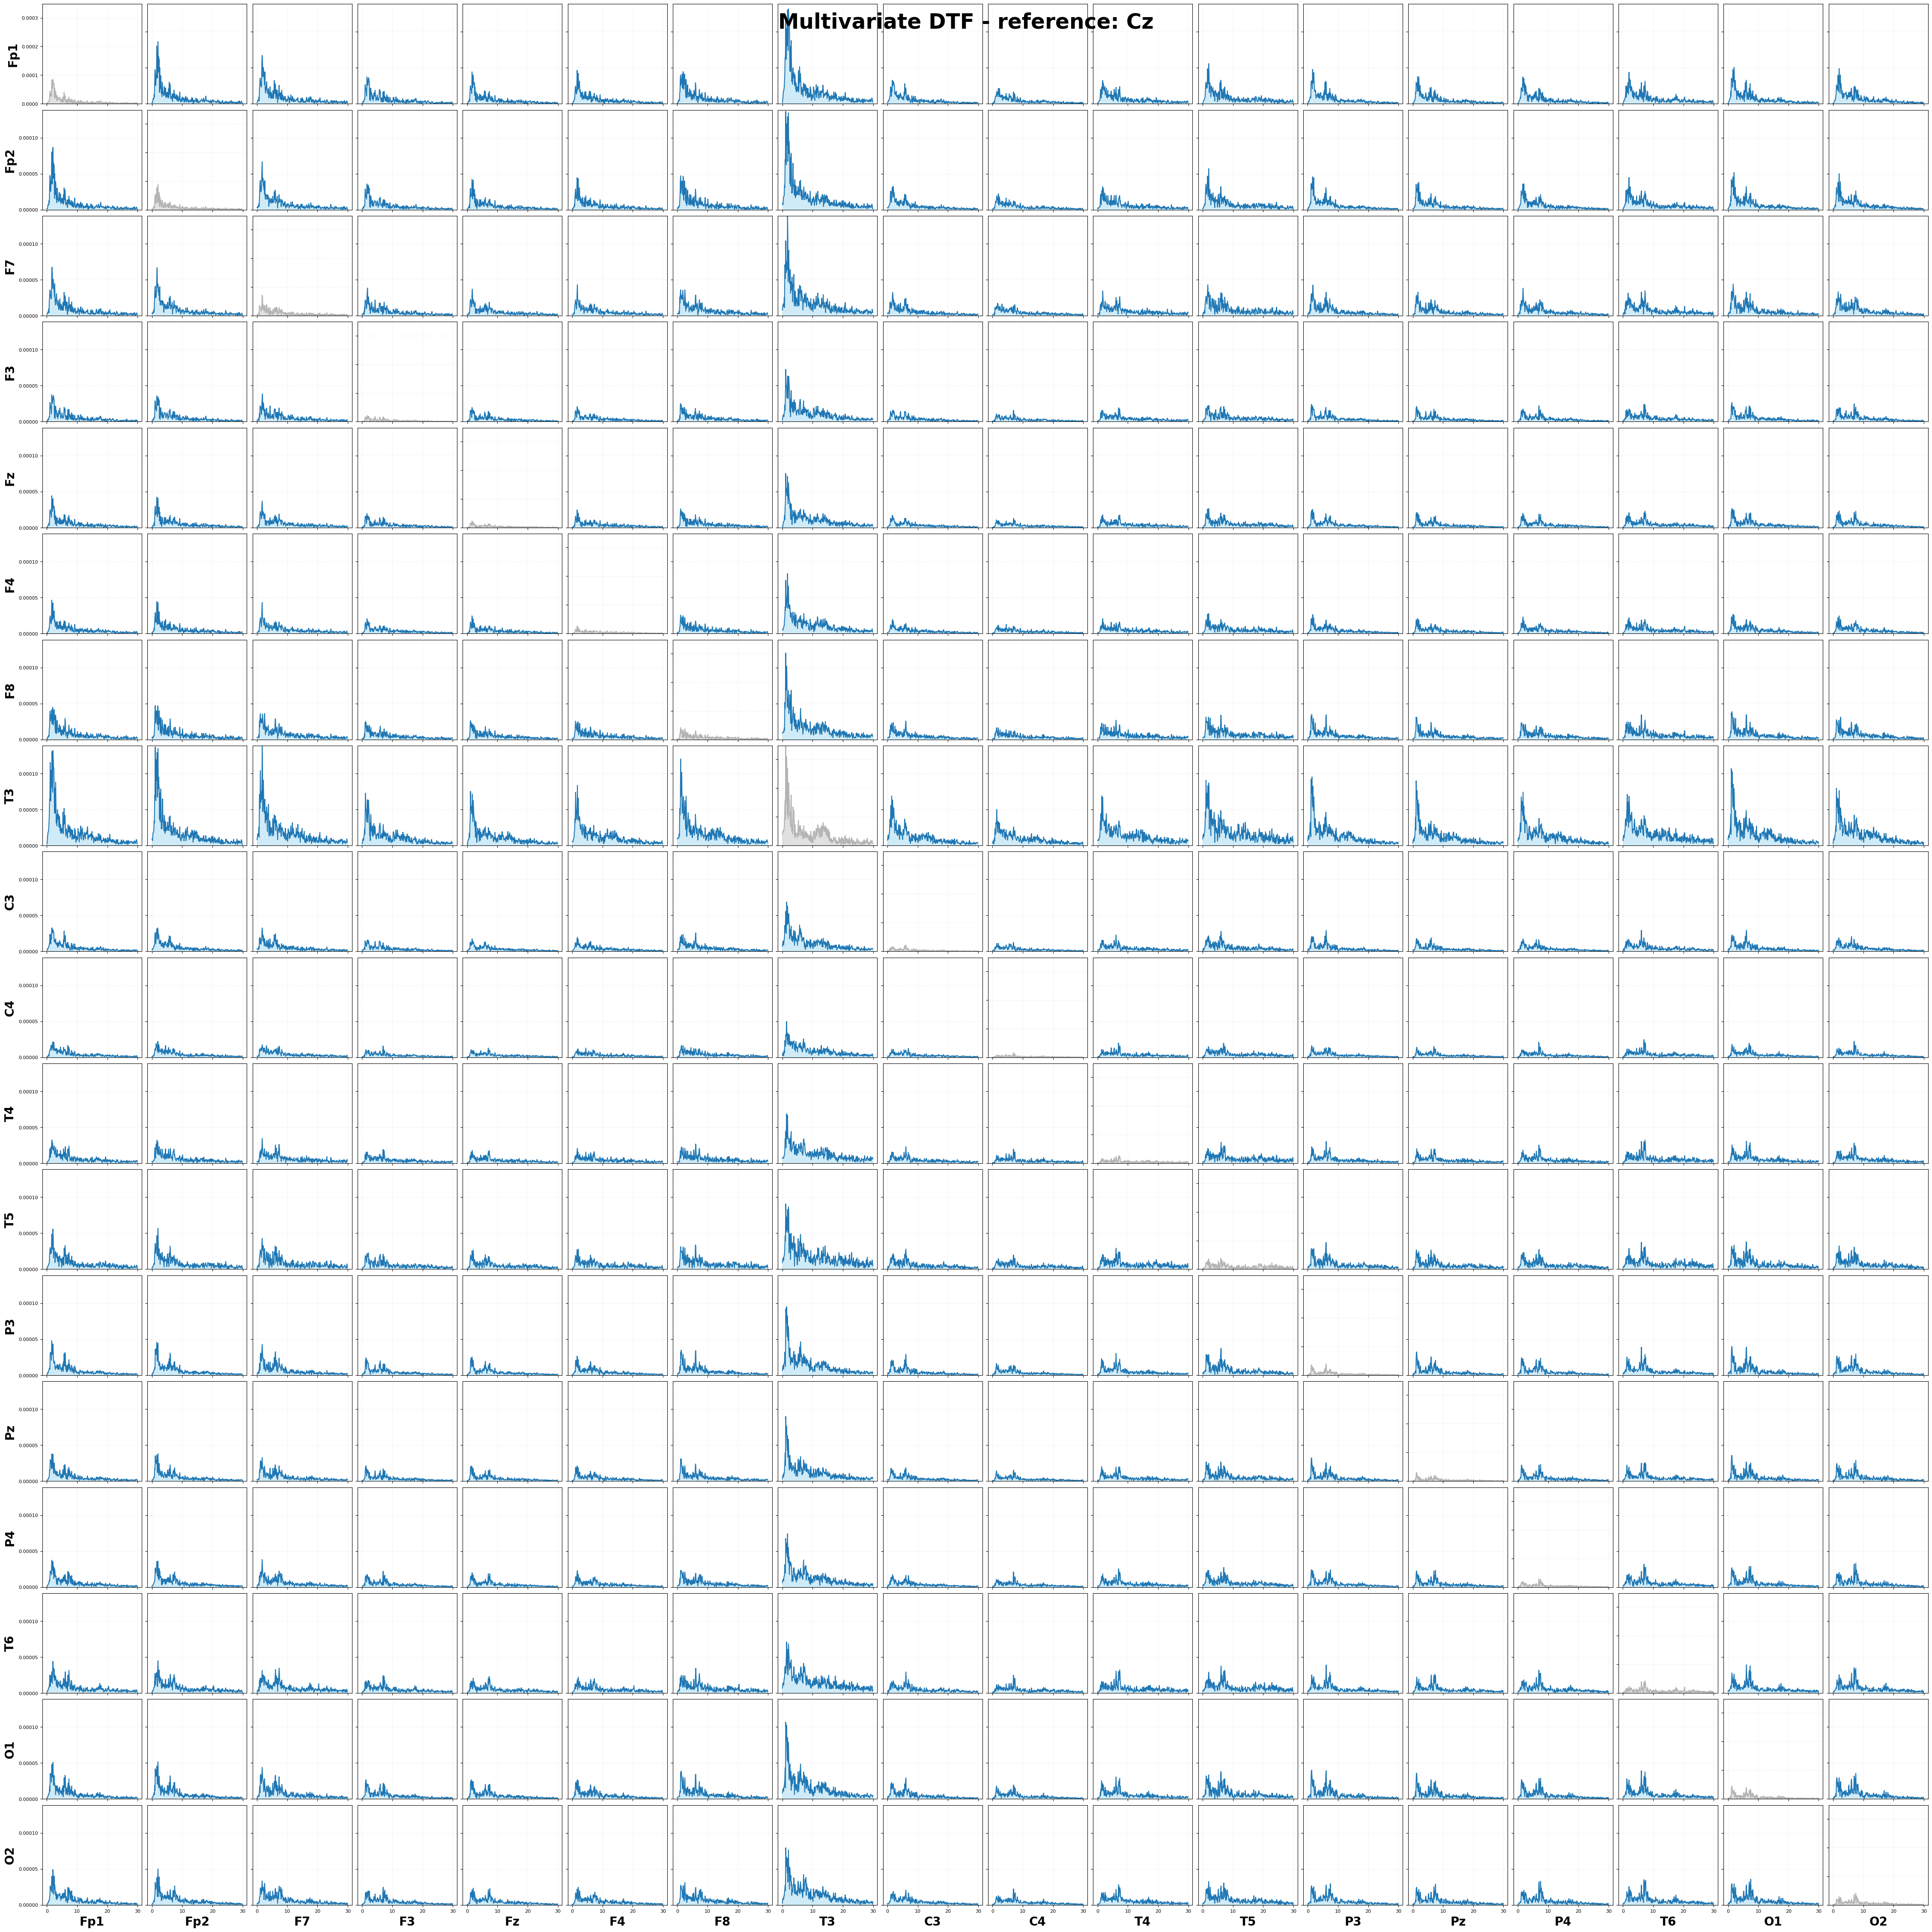

In [34]:
mvar_plot(S_multivariate, S_multivariate,   f, '', '', CH_NAMES_no_ref, 'Multivariate DTF - reference: Cz' ,'sqrt')
plt.show()